In [1]:
import notebook_functions
reload(notebook_functions)
from notebook_functions import *
import os, pandas as pd, cPickle as pickle
from nolearn.lasagne.visualize import plot_conv_activity, plot_conv_weights, plot_occlusion
from lasagne.layers import get_output, get_output_shape
import theano.tensor as T
import theano
%pylab inline

Couldn't import dot_parser, loading of dot files will not be possible.
Populating the interactive namespace from numpy and matplotlib

Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, CuDNN 4004)

pylab import has clobbered these variables: ['ceil', 'floor']
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
val_dir =  "/media/dylan/Science/Kaggle-Data/distracted_drivers/test/"

In [13]:
def image_gen_from_dir_with_filenames(data_dir, batches, size):
    result = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir) 
                  for f in filenames if os.path.splitext(f)[1] == '.jpg']
    image_files = []
    filenames = []
    for file_path in result:
        image_files.append(read_img_file_PIL(file_path, size=input_volume_shape))
        filenames.append(os.path.basename(file_path))
        if len(image_files) == batches:
            X = np.asarray(image_files, dtype=np.float32)
            X = exposure.rescale_intensity(X, out_range=(-1,1))
            yield X, filenames
            image_files = []
            filenames = []
            
    # end result loop, yield any leftover image files
    X = np.asarray(image_files, dtype=np.float32)
    X = exposure.rescale_intensity(X, out_range=(-1,1))
    yield X, filenames

In [4]:
X, filenames = image_gen_from_dir_with_filenames(val_dir, 20, input_volume_shape).next()

In [5]:
dir_name = 'net.vgg.large'
validation_file_name = "{}/vloss-{}.txt".format(dir_name, dir_name)
model_file_name = "{}/{}.pickle".format(dir_name, dir_name)
best_weights_file_name = "{}/bw-{}.weights".format(dir_name, dir_name)

In [6]:
with open(model_file_name, 'rb') as reader:
    net = pickle.load(reader)

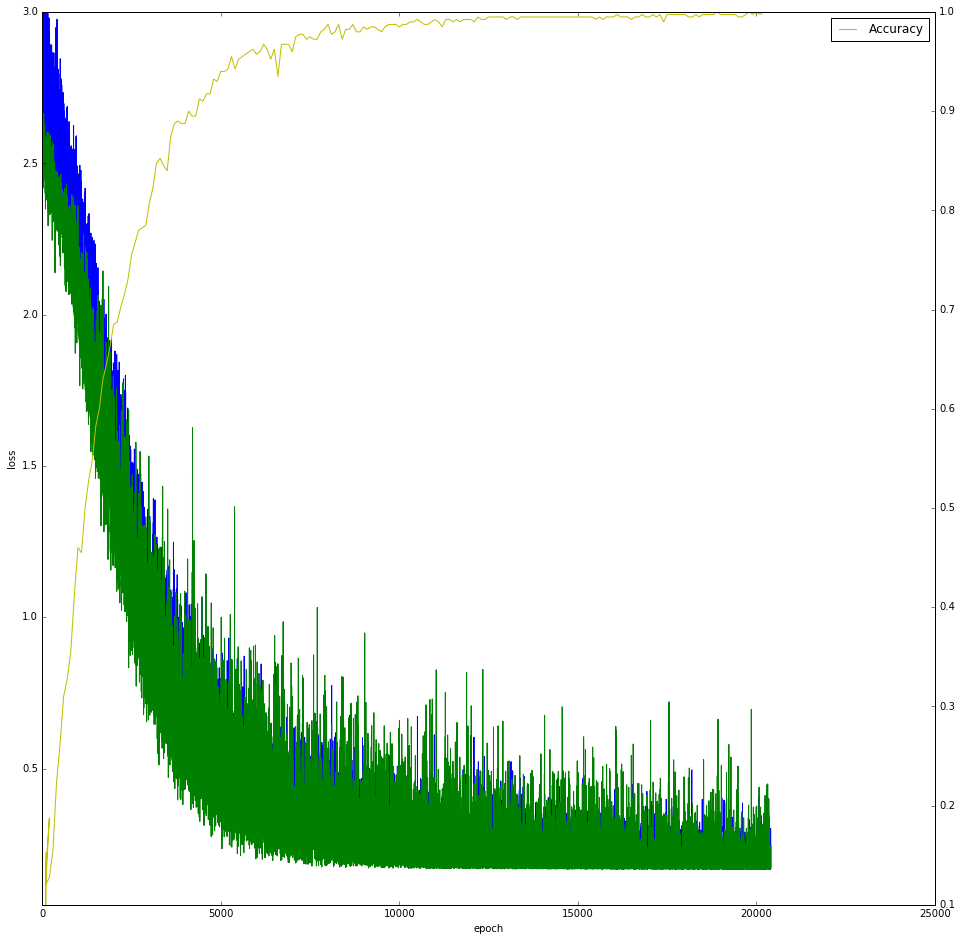

In [7]:
plot_validation_loss(net, validation_file_name,ylim=[0.05,3])

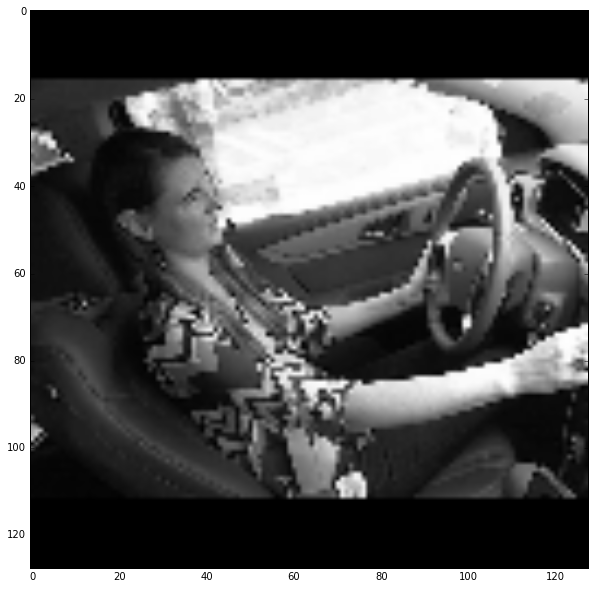

In [7]:
sample = X[0].reshape(1, 1, X[0].shape[0], X[0].shape[1])
plt.figure(figsize=(10,10))
plt.imshow(X[0], cmap='gray')
plt.show()

Original layer shape: (32, 128, 128)
Last shape: (6, 129, 6, 129)
Visualization shape (774, 774):
Prediction 5. [[  3.20868609e-10   1.35537961e-17   2.77228913e-12   2.28307770e-14
    7.74980407e-16   1.00000000e+00   5.35177810e-16   1.72117138e-12
    4.31546188e-11   2.39522469e-09]].


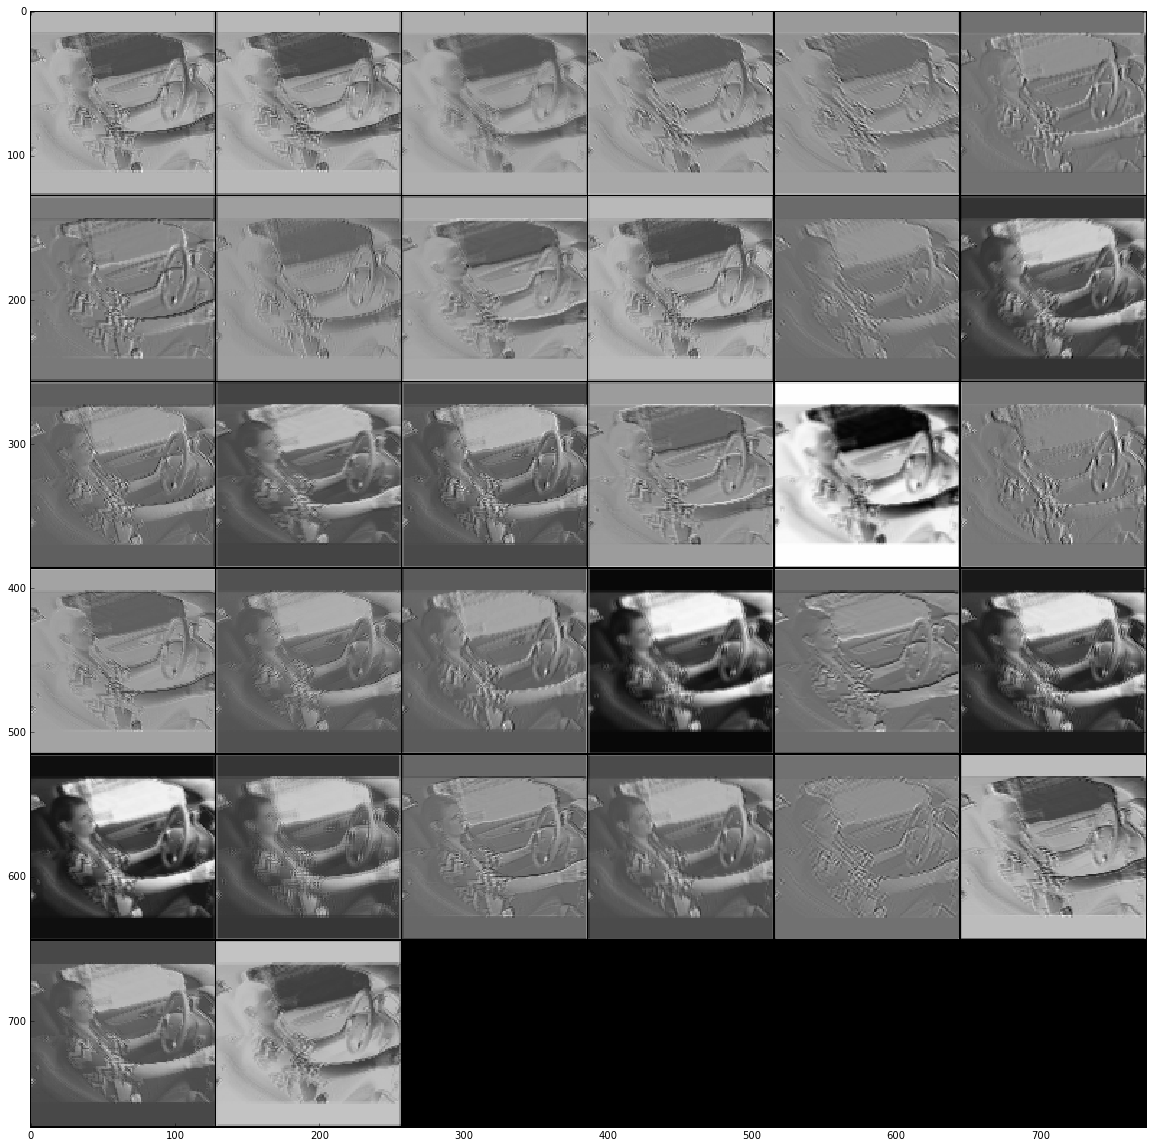

In [8]:
xs = T.tensor4('xs').astype(theano.config.floatX)
get_activity = theano.function([xs], get_output(net.layers_[1], xs))
sample = np.float32(X[0].reshape((1,1,128,128)))
activity = get_activity(sample)
activityS = activity.shape
vis_square(activity.reshape((activityS[1], activityS[2], activityS[3])))
probs = net.predict_proba(sample)
pred = np.argmax(probs)
print("Prediction {}. {}.".format(pred, probs))
plt.show()

# Evaluation Proper

In [14]:
image_gen = image_gen_from_dir_with_filenames(val_dir, 40, input_volume_shape)
threaded_gen = threaded_generator(image_gen, num_cached=40)

all_probs = []
all_file_names = []
for X, file_names in threaded_gen:
    all_probs.extend(net.predict_proba(X.reshape(-1, 1, input_volume_shape[0], input_volume_shape[1])))
    all_file_names.extend(file_names)

In [15]:
df = pd.DataFrame(np.asarray(all_probs), 
                  index = all_file_names, columns=["c0","c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9"])
df.index.name = 'img'
df.shape

(79726, 10)

In [16]:
df.to_csv("preds.csv")

In [12]:
!head preds.csv

img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img_73540.jpg,3.20862669767e-10,1.35536893448e-17,2.77221583363e-12,2.28306567038e-14,7.7496404891e-16,1.0,5.35165051075e-16,1.72112140078e-12,4.31539318169e-11,2.39516451117e-09
img_9672.jpg,2.30800173995e-06,3.77175956601e-06,0.990980684757,2.39101027866e-09,2.66834877038e-06,0.000379205623176,0.000312981486786,0.00231326324865,0.00320738274604,0.0027978613507
img_49295.jpg,1.06814346257e-09,9.71926315471e-13,2.97894131585e-09,1.09787450242e-07,0.999999046326,4.47548380578e-08,3.70307645881e-07,5.13315410143e-13,4.64205783146e-07,3.61456975462e-10
img_91517.jpg,0.00878509879112,4.69848205481e-12,1.70970806956e-11,7.64199796777e-07,6.00620619906e-09,0.991210699081,1.61961817655e-12,1.64262288667e-12,1.09826096661e-07,3.45927901435e-06
img_51925.jpg,0.758156836033,1.49232150193e-07,8.89189237796e-08,0.000138101080665,6.77587013342e-05,0.236802041531,3.41832304684e-08,6.33760866009e-09,0.000492806779221,0.0043421536684
img_87962.jpg,1.03585935944e-13,2.